<a href="https://colab.research.google.com/github/yananma/5_programs_per_day/blob/master/0429.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3.16 实战 Kaggle 比赛：房价预测

In [0]:
# !pip install mxnet d2lzh

In [3]:
!git clone https://github.com/d2l-ai/d2l-zh.git

Cloning into 'd2l-zh'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15702 (delta 9), reused 8 (delta 4), pack-reused 15685
Receiving objects: 100% (15702/15702), 159.56 MiB | 33.90 MiB/s, done.
Resolving deltas: 100% (11132/11132), done.


In [0]:
!mkdir ../data

In [5]:
!ls d2l-zh/data/

airfoil_self_noise.dat	kaggle_cifar10		    kaggle_house_pred_train.csv
fr-en-small.txt		kaggle_dog		    ptb.zip
jaychou_lyrics.txt.zip	kaggle_house_pred_test.csv


In [0]:
!cp d2l-zh/data/kaggle_house_pred_test.csv ../data/

In [0]:
!cp d2l-zh/data/kaggle_house_pred_train.csv ../data/

**Reinit**
</br>

In [0]:
%matplotlib inline 
import d2lzh as d2l 
from mxnet import autograd, gluon, init, nd 
from mxnet.gluon import data as gdata, loss as gloss, nn 
import numpy as np 
import pandas as pd 

In [0]:
train_data = pd.read_csv('../data/kaggle_house_pred_train.csv')
test_data = pd.read_csv('../data/kaggle_house_pred_test.csv')

In [248]:
train_data.shape 

(1460, 81)

In [249]:
test_data.shape 

(1459, 80)

In [250]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [0]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [0]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index 
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [253]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape 

(2919, 331)

In [0]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

In [0]:
loss = gloss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(128))
    net.add(nn.Dense(1))
    net.initialize()
    return net 

In [0]:
def log_rmse(net, features, labels):
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

In [0]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [0]:
def get_k_fold_data(k, i, X, y):
    assert k > 1 
    fold_size = X.shape[0] // k 
    X_train, y_train = None, None 
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part 
        elif X_train is None:
            X_train, y_train = X_part, y_part 
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid 

In [0]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0 
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse', 
                  range(1, num_epochs + 1), valid_ls, ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' 
          % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k 

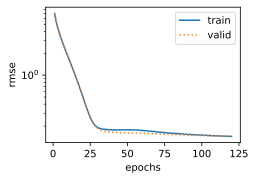

fold 0, train rmse 0.144155, valid rmse 0.145845
fold 1, train rmse 0.135420, valid rmse 0.147742
fold 2, train rmse 0.136172, valid rmse 0.164632
3-fold validation: avg train rmse 0.138583, avg valid rmse 0.152740


In [260]:
k, num_epochs, lr, weight_decay, batch_size = 3, 120, 0.01, 5, 64 
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' 
    % (k, train_l, valid_l))

In [0]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

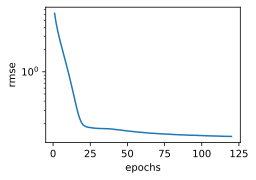

train rmse 0.132427


In [262]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)